In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../core/output/pitchers.csv')
indexer = df.reset_index()[['index', 'retroID']].to_dict()['retroID']
y = df['Pitching'].values

In [3]:
df

,retroID,BAOpp,CG,SHO,IPouts,H,ER,HR,BB,SO,...,IP,K/9,BB/9,HR/9,BABIP,LOB%,ERA,FIP,WAR,Pitching
0,aardd001,0.2574,0,0,1011,296,160,41,183,340,...,0.062360,9.08,4.89,1.09,0.285,74.5,4.27,4.45,1.1,0.602913
1,aased001,0.2508,22,5,3328,1085,468,89,457,641,...,0.205233,5.20,3.71,0.72,0.282,73.4,3.80,3.85,11.7,0.636924
2,abadf001,0.2447,0,0,992,309,135,42,116,280,...,0.061102,7.62,3.16,1.14,0.281,77.7,3.67,4.24,0.6,0.603736
3,abbog001,0.2786,37,5,3858,1405,627,162,352,484,...,0.237967,3.39,2.46,1.13,0.278,69.3,4.39,4.46,10.2,0.628847
4,abboj001,0.2804,31,6,5022,1779,791,154,620,888,...,0.309765,4.77,3.33,0.83,0.295,70.0,4.25,4.25,22.7,0.666725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8020,zolds101,0.2700,30,5,2788,956,366,54,301,207,...,0.171925,2.00,2.91,0.52,0.267,70.7,3.54,3.80,9.3,0.630540
8021,zubeb101,0.2717,23,3,2358,767,374,35,468,383,...,0.145445,4.39,5.36,0.40,0.283,69.0,4.28,3.96,3.3,0.610437
8022,zumaj001,0.2286,0,0,629,169,71,18,114,210,...,0.038711,9.01,4.89,0.77,0.267,78.7,3.00,3.94,2.7,0.612847
8023,zuveg101,0.2760,9,2,1927,660,253,56,203,223,...,0.118817,3.12,2.84,0.78,0.270,73.2,3.54,3.93,1.9,0.608497


<h2>Building the Model</h2>

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X = df.drop(columns=['Pitching']).values
y = df[['retroID', 'Pitching']].values

<p>When we do our train-test split, since it's random in how it splits up the data, we need to keep track of the appropriate keys (retro IDs) for each data point.</p>

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train_keys = np.asarray([x[0] for x in X_train])
X_train = np.asarray([x[1:] for x in X_train])
X_test_keys = np.asarray([x[0] for x in X_test])
X_test = np.asarray([x[1:] for x in X_test])
y_train_keys = np.asarray([y[0] for y in y_train])
y_train = np.asarray([y[1] for y in y_train])
y_test_keys = np.asarray([y[0] for y in y_test])
y_test = np.asarray([y[1] for y in y_test])

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

In [8]:
X_train.shape

(6420, 29)

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
def to_tensor_input(player):
    return scaler.transform(player.values.reshape(-1,29))[0]

In [12]:
tensor = df.drop(columns=['retroID', 'Pitching'])
player_tensor_inputs = tensor.apply(lambda player: to_tensor_input(player), axis=1)

In [13]:
player_tensor_inputs

0       [0.2574, 0.0, 0.0, 0.06256962495358337, 0.0599...
1       [0.2508, 0.06567164179104477, 0.08196721311475...
2       [0.2447, 0.0, 0.0, 0.06139373684861988, 0.0625...
3       [0.2786, 0.11044776119402985, 0.08196721311475...
4       [0.2804, 0.09253731343283582, 0.09836065573770...
                              ...                        
8020    [0.27, 0.08955223880597014, 0.0819672131147541...
8021    [0.2717, 0.06865671641791045, 0.04918032786885...
8022    [0.2286, 0.0, 0.0, 0.03892808515905434, 0.0342...
8023    [0.276, 0.026865671641791045, 0.03278688524590...
8024    [0.2183, 0.0, 0.0, 0.013491768783265256, 0.011...
Length: 8025, dtype: object

In [14]:
tensor = pd.DataFrame(player_tensor_inputs.values.tolist())

In [15]:
tensor.to_csv('../core/tensors/t_pitching.csv', index=False, float_format='%g')

In [17]:
epochs = 4000
batch_size = 32
loss_param = 'mse'
optimizer_param = 'adam'
stop_monitor = 'val_loss'
stop_patience = 50

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
early_stop = EarlyStopping(monitor=stop_monitor, patience=stop_patience)

In [20]:
model = Sequential()

model.add(Dense(29, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.5))

model.add(Dense(58, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss=loss_param, optimizer=optimizer_param)

In [21]:
results = model.fit(x=X_train, y=y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stop]
                    )

Train on 6420 samples, validate on 1605 samples
Epoch 1/4000
6420/6420 [==============================] - 1s 183us/sample - loss: 0.0069 - val_loss: 0.0035
Epoch 2/4000
6420/6420 [==============================] - 0s 66us/sample - loss: 0.0033 - val_loss: 0.0021
Epoch 3/4000
6420/6420 [==============================] - 0s 51us/sample - loss: 0.0021 - val_loss: 0.0013
Epoch 4/4000
6420/6420 [==============================] - 0s 49us/sample - loss: 0.0015 - val_loss: 8.8244e-04
Epoch 5/4000
6420/6420 [==============================] - 0s 46us/sample - loss: 0.0011 - val_loss: 6.9195e-04
Epoch 6/4000
6420/6420 [==============================] - 0s 50us/sample - loss: 9.0205e-04 - val_loss: 5.2742e-04
Epoch 7/4000
6420/6420 [==============================] - 0s 52us/sample - loss: 7.3946e-04 - val_loss: 4.4965e-04
Epoch 8/4000
6420/6420 [==============================] - 0s 49us/sample - loss: 6.7641e-04 - val_loss: 4.5362e-04
Epoch 9/4000
6420/6420 [==============================] - 0s 53

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  870       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1740      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  59        
Total params: 2,669
Trainable params: 2,669
Non-trainable params: 0
_________________________________________________________________


In [23]:
import os

In [24]:
losses = model.history.history
losses['loss'] = np.asarray(losses['loss'])
losses['val_loss'] = np.asarray(losses['val_loss'])
final_number_of_epochs = len(losses['loss'])
min_loss = losses['loss'].min()
mean_loss = losses['loss'].mean()
final_loss = losses['loss'][-1]
min_val_loss = losses['val_loss'].min()
mean_val_loss = losses['val_loss'].mean()
final_val_loss = losses['val_loss'][-1]

def get_model_summary():
    output = []
    model.summary(print_fn=lambda line: output.append(line))
    return str(output).strip('[]')

summary = get_model_summary()

record = {
    'Epochs': final_number_of_epochs,
    'Batch_Size': batch_size,
    'Loss_Func': loss_param,
    'Optimizer': optimizer_param,
    'Early_Stop_Monitor': stop_monitor,
    'Early_Stop_Patience': stop_patience,
    'Min_Loss': min_loss,
    'Mean_Loss': mean_loss,
    'Final_Loss': final_loss,
    'Min_Val_Loss': min_val_loss,
    'Mean_Val_Loss': mean_val_loss,
    'Final_Val_Loss': final_val_loss,
    'Model': summary
}

new_data = pd.DataFrame(record, index=[0])

if os.path.exists('../core/records/pitching_results.csv'):
    df_records = pd.read_csv('../core/records/pitching_results.csv')
    df_records = df_records.append(new_data)
else:
    df_records = pd.DataFrame(new_data)
    
df_records.to_csv('../core/records/pitching_results.csv', index=False, float_format='%g')

<h2>Model Evaluation</h2>

In [25]:
losses = pd.DataFrame(model.history.history)

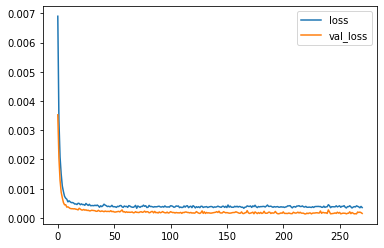

In [26]:
losses.plot()

In [27]:
predictions = model.predict(X_test)
predictions = [pred for sublist in predictions for pred in sublist]

In [28]:
test_player_ratings = dict(zip(X_test_keys, predictions))

In [29]:
player_key = df['retroID']

In [30]:
player_key

0       aardd001
1       aased001
2       abadf001
3       abbog001
4       abboj001
          ...   
8020    zolds101
8021    zubeb101
8022    zumaj001
8023    zuveg101
8024    zycht001
Name: retroID, Length: 8025, dtype: object

In [31]:
results = model.predict(tensor.to_numpy())

In [32]:
len(results)

8025

In [33]:
results.mean()

0.6065751

In [34]:
df['Pitching'].shape

(8025,)

In [35]:
results.shape

(8025, 1)

In [36]:
results = [pred for sublist in results for pred in sublist]

In [37]:
diff = df['Pitching'] - results

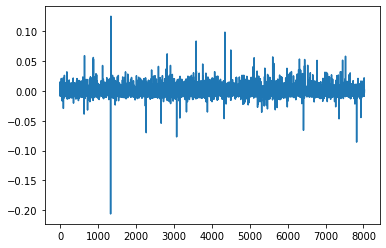

In [38]:
diff.plot()

In [39]:
diff.mean()

-0.0009138342898704561